# 04 – Outlier Treatment
     Detecting, Understanding, and Handling Extreme Values Without Destroying Signal
## Objective

This notebook provides a systematic treatment of outlier detection and treatment, covering:

- What outliers are (statistical vs business perspective)
- Univariate and multivariate detection techniques
- Robust vs aggressive treatment strategies
- When to cap, transform, or ignore outliers
- Leakage-safe outlier handling inside pipelines

It answers:

**How do we manage extreme values without removing valid business signal or biasing models?**
## Why Outliers Matter

Incorrect handling of outliers can:

- Distort parameter estimates
- Break distance-based models
- Inflate variance and instability
- Hide rare but important business cases

Outliers are **not always errors** — context matters.
## Imports and Dataset


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [3]:
df = pd.read_csv("../datasets/synthetic_customer_churn_classification_complete.csv")
df.head()


,customer_id,age,income,tenure_years,avg_monthly_usage,support_tickets_last_year,satisfaction_level,customer_segment,region,churn,future_retention_offer
0,1,18,NaN,2.012501,138.021163,1,NaN,segment_18,South,0,-0.069047
1,2,18,58991.061162,9.005550,213.043003,2,Very High,segment_98,West,0,-0.226607
2,3,67,31130.298545,3.633058,68.591582,2,Medium,segment_134,North,0,-0.065741
3,4,64,NaN,4.295957,28.790894,1,NaN,segment_72,North,0,0.061886
4,5,37,22301.231175,2.549855,100.136569,2,High,segment_147,East,1,1.073678


## Numeric Feature Selection

In [4]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

numeric_features.remove("churn")
numeric_features.remove("customer_id")

numeric_features


['age',
 'income',
 'tenure_years',
 'avg_monthly_usage',
 'support_tickets_last_year',
 'future_retention_offer']

# Distribution Diagnostics

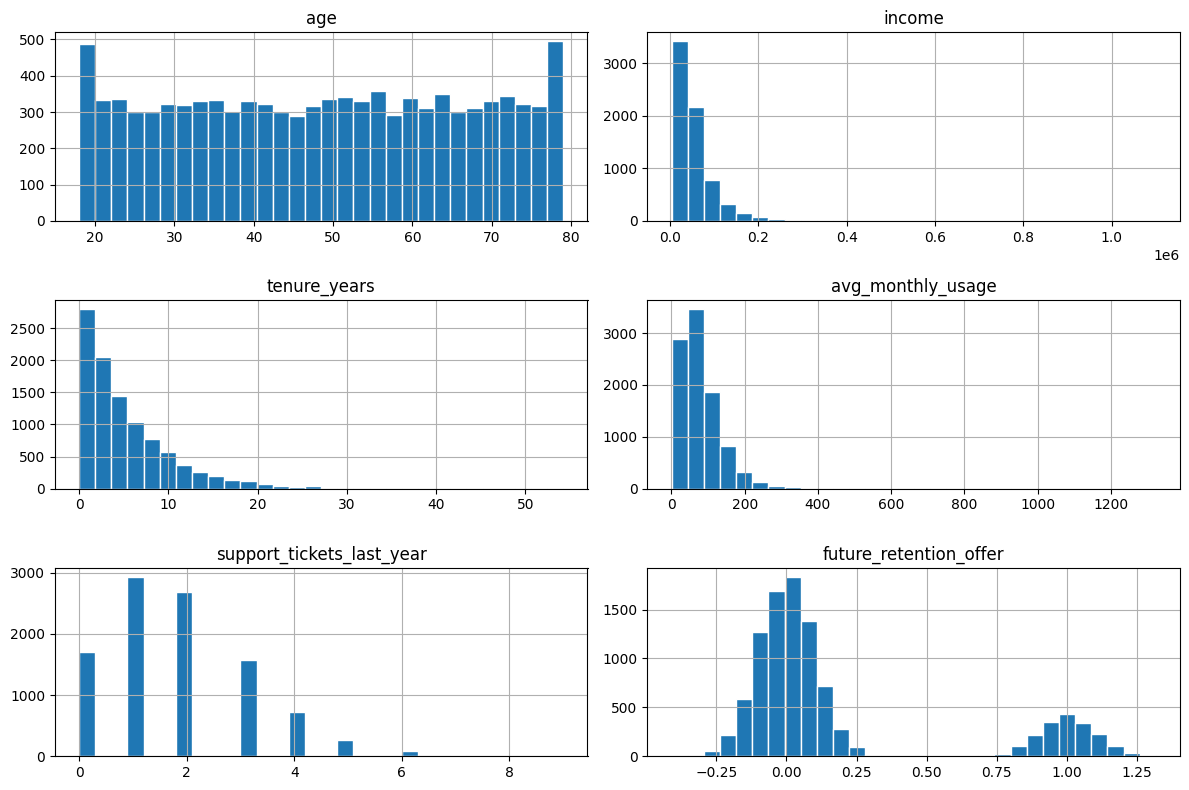

In [18]:
df[numeric_features].hist(bins=30, figsize=(12, 8), edgecolor='white')
plt.tight_layout()
plt.show()


### Observations

- Heavy right skew in monetary variables
- Long tails in usage and tenure
- Extreme values may still be valid business cases


# Boxplot Analysis (Visual Outlier Detection)


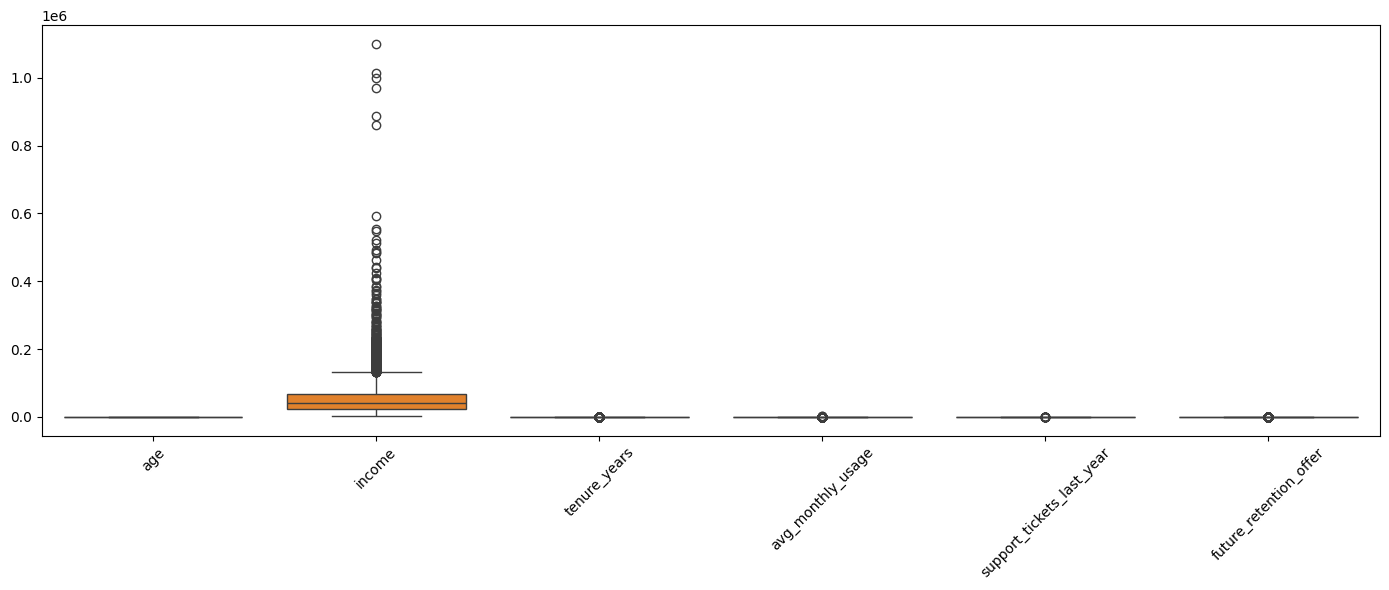

In [19]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[numeric_features])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Step 4 – Z-Score Method

**When to use**
- Approximately normal distributions

**Limitations**
- Sensitive to skewness
- Poor performance on heavy-tailed data



#  IQR Method (Robust Default)

**Why IQR**
- Distribution-free
- Robust to skew
- Industry default for tabular business data



In [22]:
Q1 = df[numeric_features].quantile(0.25)
Q3 = df[numeric_features].quantile(0.75)
IQR = Q3 - Q1

iqr_outliers = (
    (df[numeric_features] < (Q1 - 1.5 * IQR)) |
    (df[numeric_features] > (Q3 + 1.5 * IQR))
).any(axis=1)

iqr_outliers

0       False
1        True
2       False
3       False
4        True
        ...  
9995    False
9996     True
9997    False
9998    False
9999     True
Length: 10000, dtype: bool

In [20]:
iqr_outliers.mean()

np.float64(0.292)

# Multivariate Perspective

Outliers may not be extreme in a single variable, but anomalous when considering **feature combinations**.


In [21]:
df.loc[iqr_outliers, numeric_features].describe()

,age,income,tenure_years,avg_monthly_usage,support_tickets_last_year,future_retention_offer
count,2920.000000,2.126000e+03,2920.000000,2814.000000,2920.000000,2920.000000
mean,48.792466,7.062560e+04,6.175835,107.347656,2.190068,0.634379
std,17.963652,8.914777e+04,7.867601,98.350492,1.493335,0.494521
min,18.000000,3.325614e+03,0.000661,0.918340,0.000000,-0.410335
25%,33.000000,2.167946e+04,1.183232,48.874537,1.000000,0.048522
50%,49.000000,3.681892e+04,2.722153,81.381080,2.000000,0.919612
75%,64.000000,8.155906e+04,7.070276,134.928012,3.000000,1.027273
max,79.000000,1.100058e+06,54.238486,1322.966577,9.000000,1.318369


# Outlier Treatment: Winsorization (Capping)

**When to use**
- Heavy tails
- Valid but extreme business values

**Why**
- Preserves row count
- Limits extreme influence


In [24]:
df_capped = df.copy()

for col in numeric_features:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df_capped[col] = df[col].clip(lower, upper)

df_capped[numeric_features].describe()


,age,income,tenure_years,avg_monthly_usage,support_tickets_last_year,future_retention_offer
count,10000.000000,7000.000000,10000.000000,9600.000000,10000.000000,10000.000000
mean,48.621100,53739.621896,5.385943,78.913120,1.792400,0.185532
std,17.922116,43566.276845,5.159072,54.398562,1.339209,0.400256
min,18.000000,7453.532299,0.063476,7.215945,0.000000,-0.217809
25%,33.000000,24298.268780,1.602746,39.688541,1.000000,-0.051412
50%,49.000000,40650.189882,3.786117,66.481462,2.000000,0.028937
75%,64.000000,67759.201650,7.560793,104.682739,3.000000,0.138283
max,79.000000,242621.462168,25.456665,285.658716,6.000000,1.163600


#  Outlier Treatment: Log Transformation

**When to use**
- Positive-only variables
- Multiplicative effects
- Strong right skew


In [28]:
log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")
log_transformed = log_transformer.fit_transform(df[numeric_features])

pd.DataFrame(log_transformed, columns=numeric_features).describe()


,age,income,tenure_years,avg_monthly_usage,support_tickets_last_year,future_retention_offer
count,10000.000000,7000.000000,10000.000000,9600.000000,10000.000000,10000.000000
mean,3.829338,10.622325,1.557799,4.141710,0.903190,0.124321
std,0.403624,0.754123,0.787608,0.756759,0.518674,0.286496
min,2.944439,8.109710,0.000661,0.264138,0.000000,-0.528201
25%,3.526361,10.098202,0.956567,3.705947,0.693147,-0.052781
50%,3.912023,10.612783,1.565719,4.211853,1.098612,0.028526
75%,4.174387,11.123730,2.147193,4.660442,1.386294,0.129521
max,4.382027,13.910874,4.011660,7.188387,2.302585,0.840864


# Robust Modeling Instead of Cleaning

Often, the safest approach is **not to remove outliers**,
but to use models and scalers that are inherently robust.


## Robust Pipeline

In [29]:
robust_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

robust_pipeline


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler())])

# Step 10 – Outlier Sensitivity by Model Type

| Model Type | Outlier Sensitivity |
|-----------|---------------------|
| Linear / Logistic | High |
| KNN / SVM | Very High |
| Neural Networks | High |
| Tree-Based Models | Low |
| Random Forest | Low |
| Gradient Boosting | Medium |






## Step 11 – Common Mistakes (Avoided)

- `[pos] - ` Removing valid business extremes
- `[pos] - ` Applying global thresholds blindly
- `[pos] - ` Treating leakage as outliers
- `[pos] - ` Handling outliers outside pipelines









# Summary Table

| Technique | Use Case |
|---------|----------|
| Z-Score | Normal data |
| IQR | Skewed business data |
| Winsorization | Heavy tails |
| Log Transform | Positive skew |
| RobustScaler | Mixed distributions |


# Key Takeaways

- Outliers are context-dependent
- Prefer robustness over deletion
- Treat outliers inside pipelines
- Business understanding must guide decisions


## Next Notebook

02_Data_Preprocessing/

└── [05_discretization_and_binning.ipynb](./05_discretization_and_binning.ipynb/)
